In [29]:
# 数据操作
import numpy as np
import pandas as pd
import os

# 绘图
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

# 深度学习框架pytorch
import torch
from torch import nn
from torch.utils import data
from torch.utils.data import DataLoader


#忽略警告信息
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [30]:
# 查看当前文件所在目录路径以及数据集文件路径，为了获取导入数据的路径
print(os.getcwd())
for dirname, _, filenames in os.walk('C:\\Users\\asunc\\Downloads\\pythoncode\\Pytorch\\houseprice'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\asunc\Downloads\pythoncode\Pytorch
C:\Users\asunc\Downloads\pythoncode\Pytorch\houseprice\data_description.txt
C:\Users\asunc\Downloads\pythoncode\Pytorch\houseprice\sample_submission.csv
C:\Users\asunc\Downloads\pythoncode\Pytorch\houseprice\test.csv
C:\Users\asunc\Downloads\pythoncode\Pytorch\houseprice\train.csv


In [31]:
train_data = pd.read_csv('C:\\Users\\asunc\\Downloads\\pythoncode\\Pytorch\\houseprice\\train.csv')
test_data = pd.read_csv('C:\\Users\\asunc\\Downloads\\pythoncode\\Pytorch\\houseprice\\test.csv')

In [32]:
# 查看数据集
print(train_data.shape, test_data.shape)
train_data.head(5)

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [33]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [34]:
# 去掉Id列
train_data.drop('Id', axis = 1, inplace = True)
test_data.drop('Id', axis = 1, inplace = True)
print(train_data.shape, test_data.shape)  # train_data和test_data都是79个特征变量，train_data还有一列SalePrice

(1460, 80) (1459, 79)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

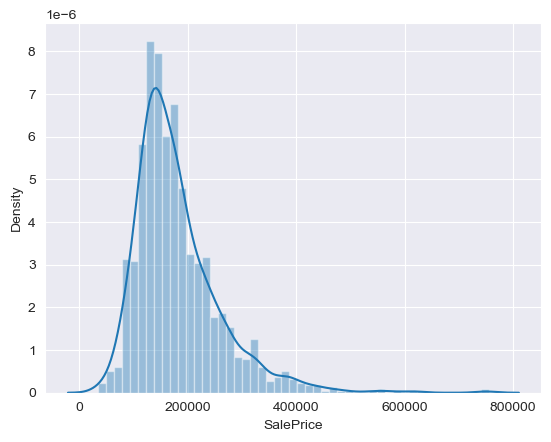

In [35]:
# 1. 绘制目标值分布
sns.distplot(train_data['SalePrice'])

In [36]:
# 查看特征类型
test_data_dtype = pd.DataFrame(test_data.dtypes, columns=['dtype'])
test_data_dtype  # 类别特征的dtype是object，其他是数字特征

,dtype
MSSubClass,int64
MSZoning,object
LotFrontage,float64
LotArea,int64
Street,object
...,...
MiscVal,int64
MoSold,int64
YrSold,int64
SaleType,object


In [37]:
# 分离数字特征和类别特征
# 注意这里用test_data来分离特征，因为train_data中有一列SalePrice是目标值，不是特征项，用train_data就不方便（非要用就把SalePrice排除）
num_features = []
cate_features = []
for col in test_data.columns:
    if test_data[col].dtype == 'object':
        cate_features.append(col)
    else:
        num_features.append(col)
print(len(num_features), len(cate_features))  # 总共有36个数字特征，43个类别特征

36 43


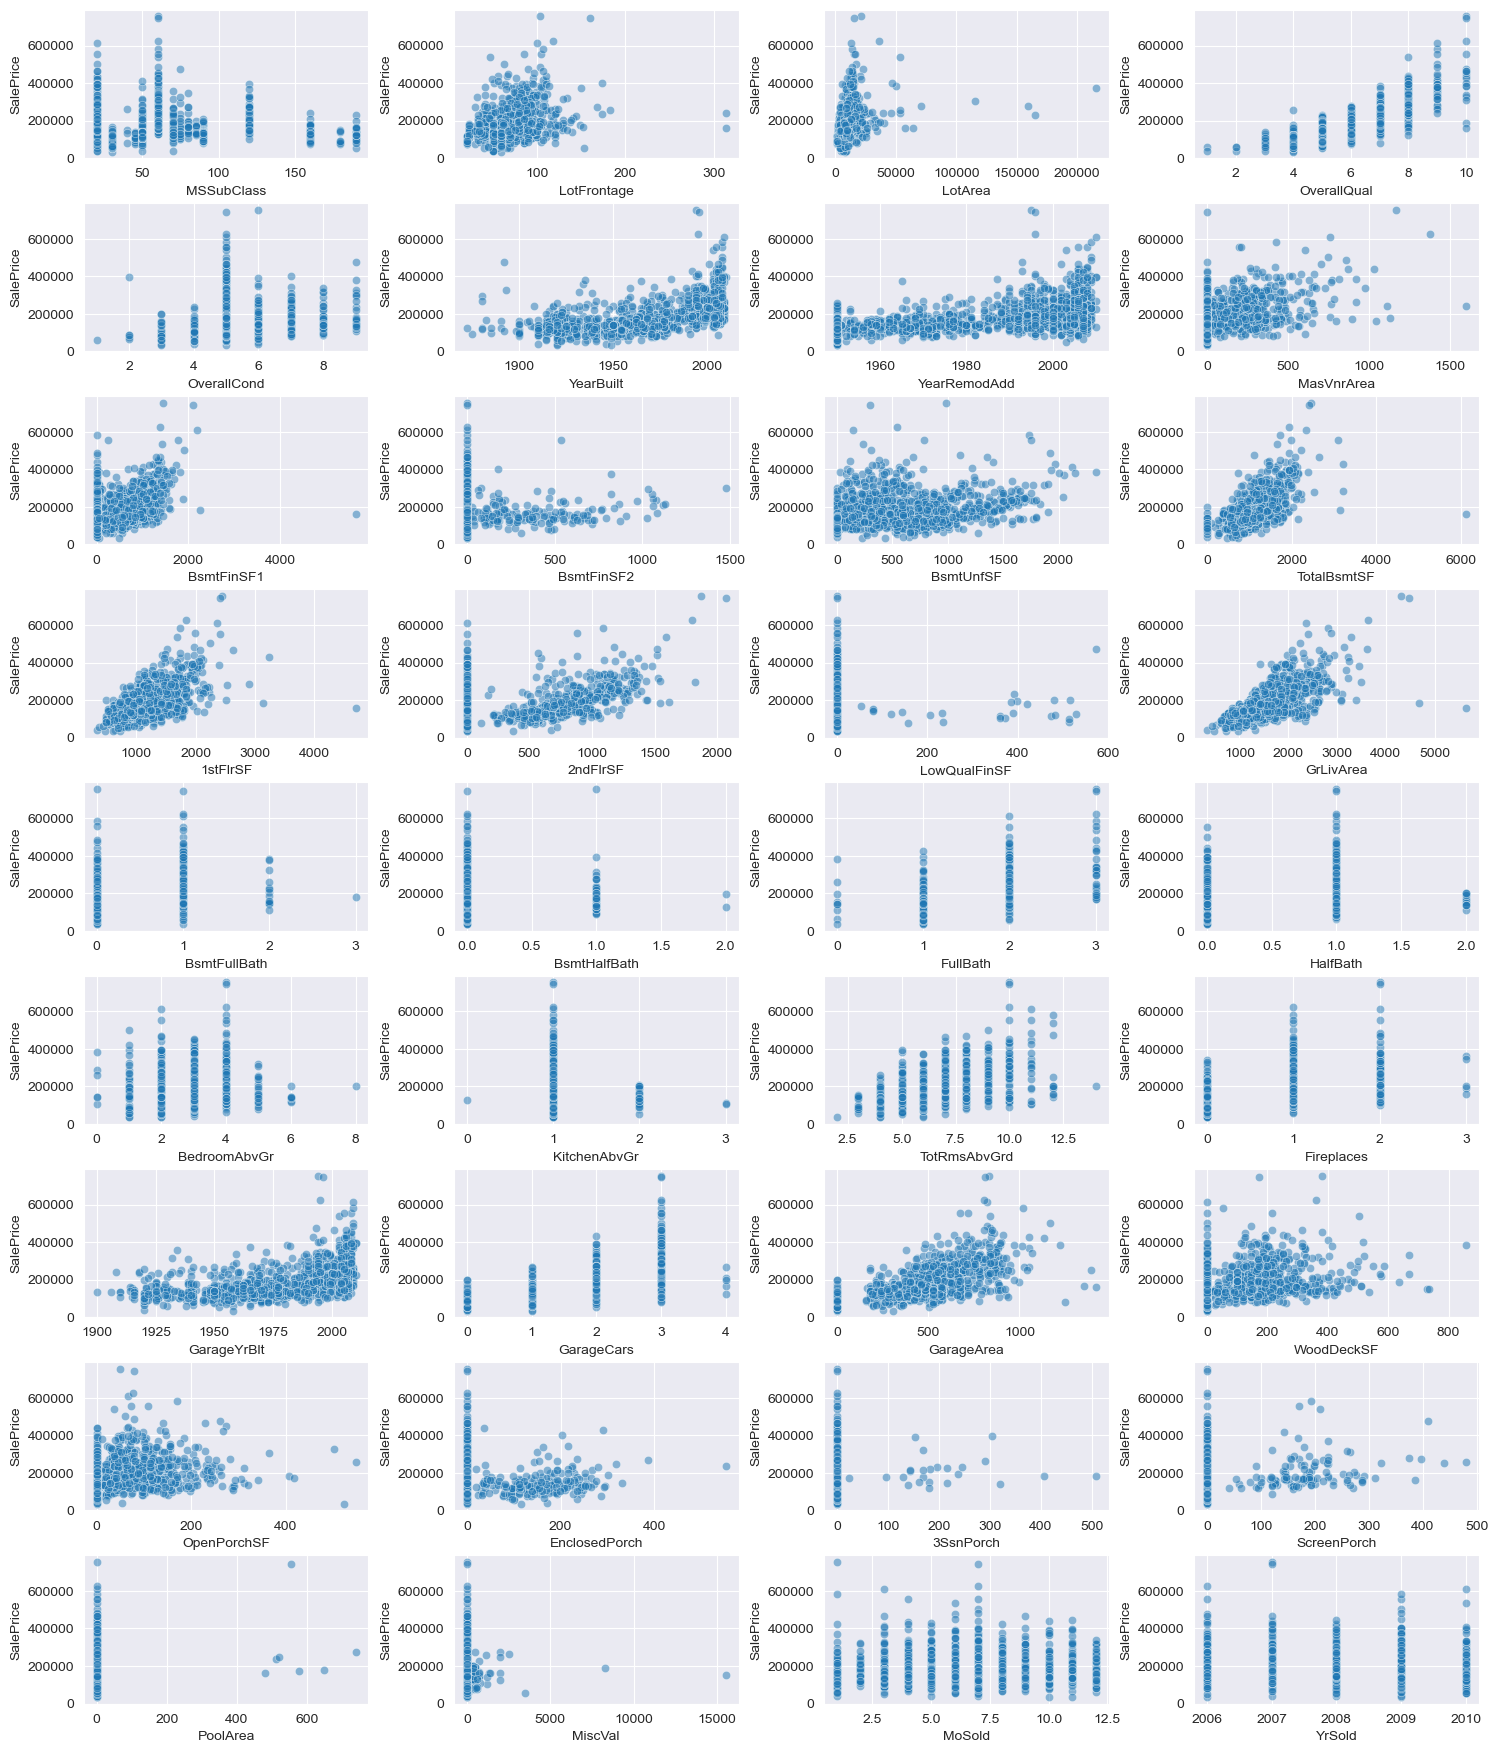

In [38]:
plt.figure(figsize=(18, 22))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for i, feature in enumerate(num_features):
    plt.subplot(9, 4, i + 1)
    sns.scatterplot(x=feature, y='SalePrice', data=train_data, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
plt.show()

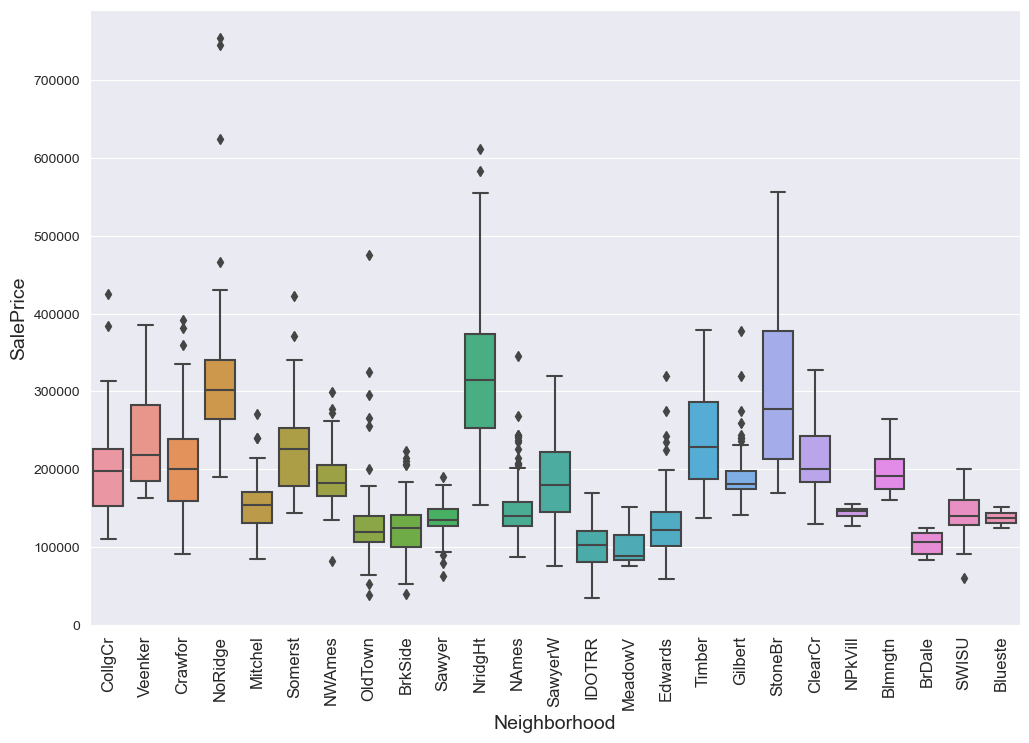

In [39]:
# 1. 查看‘Neighborhood’和目标值之间的关系（凭直觉，房子的房价往往和周围房价差不多）
plt.figure(figsize=(12, 8))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train_data)
plt.xlabel('Neighborhood', fontsize=14)
plt.ylabel('SalePrice', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.show()

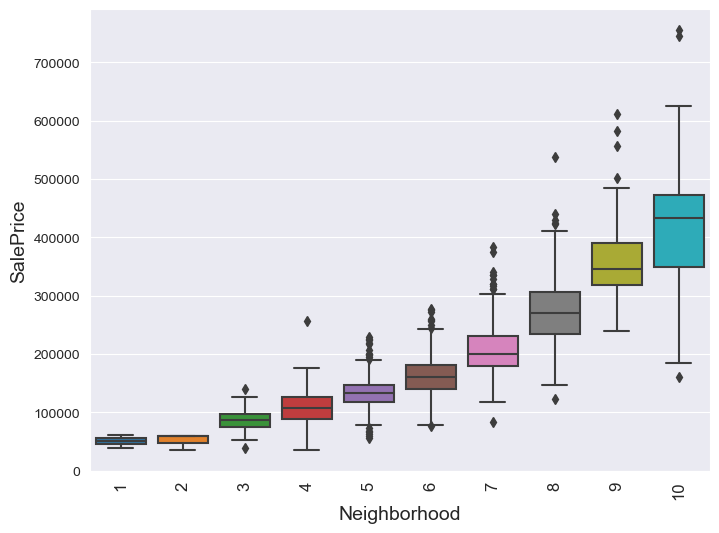

In [40]:
# 2. 查看‘OverallQual’和目标值之间的关系（房屋的整体材料和完成度的比率）
plt.figure(figsize=(8, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_data)
plt.xlabel('Neighborhood', fontsize=14)
plt.ylabel('SalePrice', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.show()

<Figure size 1000x1000 with 0 Axes>

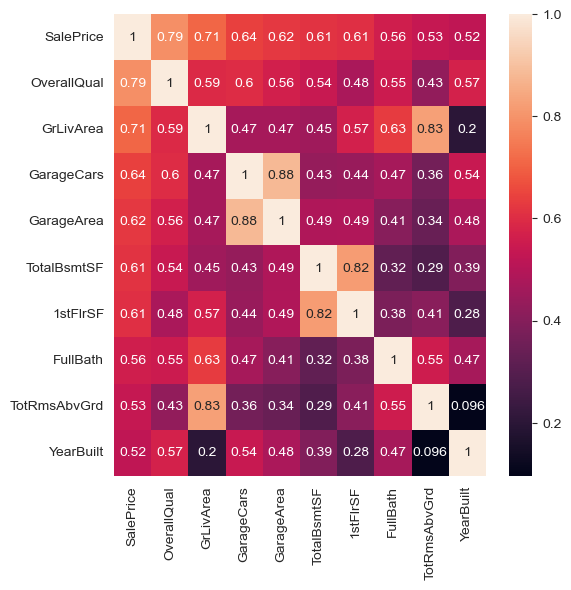

In [41]:
# 看所有特征之间的相关关系
corrs = train_data.corr()  # data.corr()表示了data中的两个变量之间的相关性
plt.figure(figsize=(10,10))
# sns.heatmap(corrs)  # 热图

# 由于特征比较多，可以取与目标值相关度最高的十个特征 绘制相关度热图
cols_10 = corrs.nlargest(10, 'SalePrice')['SalePrice'].index
corrs_10 = train_data[cols_10].corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corrs_10, annot=True)
plt.show()

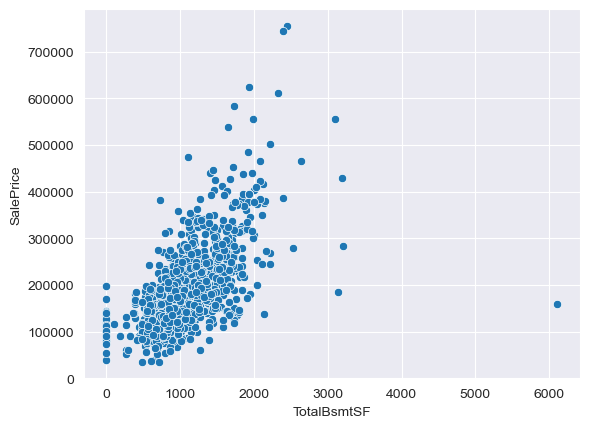

In [42]:
# 1. 观察’TotalBsmtSF’与目标值的散点图，可以看到存在异常值
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train_data)

# 处理掉右下角明显的异常值
train_data = train_data.drop(train_data[(train_data['TotalBsmtSF']>6000) & (train_data['SalePrice']<200000)].index)

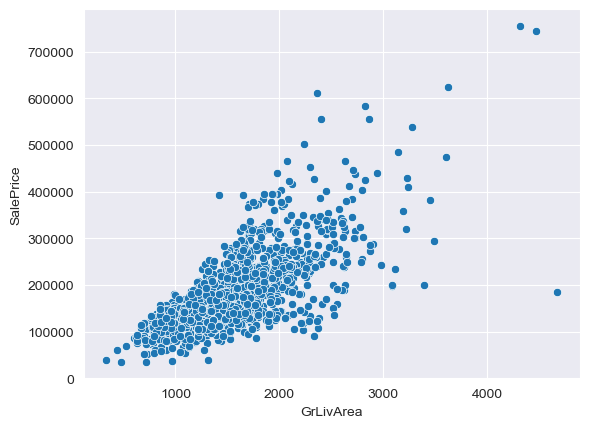

In [43]:
# 2. 观察’GrLivArea’与目标值的散点图，可以看到存在异常值
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data)
# 丢掉右下角异常值
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<200000)].index)

# 丢掉再绘图看看
# sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data)

In [44]:
# 查看训练集中各特征的缺失值个数
train_missing_total = train_data.isnull().sum().sort_values(ascending=False)
train_missing_percent = (train_data.isnull().sum() / train_data.isnull().count()).sort_values(ascending=False)
train_missing_data = pd.concat([train_missing_total, train_missing_percent], axis=1, keys=['Total', 'Percent'])
train_missing_data.head(20)

,Total,Percent
PoolQC,1452,0.995885
MiscFeature,1404,0.962963
Alley,1367,0.937586
Fence,1177,0.807270
FireplaceQu,690,0.473251
LotFrontage,259,0.177641
GarageYrBlt,81,0.055556
GarageCond,81,0.055556
GarageType,81,0.055556
GarageFinish,81,0.055556


In [45]:
# 查看测试集中缺失值个数
test_missing = test_data.isnull().sum()
test_missing = test_missing.drop(test_missing[test_missing==0].index).sort_values(ascending=False)
test_missing

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageCars         1
GarageArea         1
TotalBsmtSF        1
KitchenQual        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

In [46]:
# 一、类型特征处理（对训练集和测试集）

# 1.补充为None（根据data_description.txt，以下特征缺失值代表没有，补充为None）
none_lists = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType1',
              'BsmtFinType2', 'BsmtCond', 'BsmtExposure', 'BsmtQual', 'MasVnrType', 'Utilities']
for col in none_lists:
    train_data[col] = train_data[col].fillna('None')
    test_data[col] = test_data[col].fillna('None')
    
# 2.补充出现频率最高的一类（以下特征缺失不代表没有，只是数据丢了
most_lists = ['MSZoning', 'Exterior1st', 'Exterior2nd', 'SaleType', 'KitchenQual', 'Electrical']
for col in most_lists:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    test_data[col] = test_data[col].fillna(test_data[col].mode()[0])
    
# 二、数字特征处理（对训练集和测试集）

# 1.对可能为0的特征，缺失值补0
zero_lists = ['GarageYrBlt', 'GarageCars', 'GarageArea', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
              'TotalBsmtSF']
for col in zero_lists:
    train_data[col] = train_data[col].fillna(0)
    test_data[col] = test_data[col].fillna(0)
    
# 2. 'LotFrontage': 地块临街面积
# （由于与房产相连的每条街道的面积很可能与其附近的其他房屋具有相似的面积，so可以通过Neighborhood邻居的地块临街面积中值来填充缺失的值）
train_data['LotFrontage'] = train_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test_data['LotFrontage'] = test_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median())) 

# 三、测试集中还有其他特征存在缺失值，进行处理

# Functional：data_description.txt说NA意味着typical
test_data['Functional'] = test_data['Functional'].fillna('Typ')

# 再检查下是否还存在缺失值
print(train_data.isnull().sum().max(), test_data.isnull().sum().max())

0 0


In [47]:
# 1.把train和test的数据集拼接到一起，一起做get_dummies
all_features = pd.concat((train_data.iloc[:, 0:-1], test_data.iloc[:, 0:]))
print(all_features.shape)

# 2.做完get_dummies后，数字特征不变，类型特征已经分好了（xx列变成-> xx_1, xx_2, xx_nan, 并且去掉xx列的状态）
all_features = pd.get_dummies(all_features, dummy_na=True)
# all_features即为one-hot编码之后的所有特征列
print(all_features.shape)

(2917, 79)
(2917, 345)


In [48]:
train_num = train_data.shape[0]
train_features = torch.tensor(all_features[:train_num].values, dtype=torch.float32)
test_features = torch.tensor(all_features[train_num:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [49]:
# 封装数据
train_dataset = data.TensorDataset(train_features, train_labels)

# 加载数据
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [50]:
print(train_dataset.tensors)

(tensor([[6.0000e+01, 6.5000e+01, 8.4500e+03,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0000e+01, 8.0000e+01, 9.6000e+03,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.0000e+01, 6.8000e+01, 1.1250e+04,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [7.0000e+01, 6.6000e+01, 9.0420e+03,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0000e+01, 6.8000e+01, 9.7170e+03,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0000e+01, 7.5000e+01, 9.9370e+03,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00]]), tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]]))


In [51]:
from IPython import display 

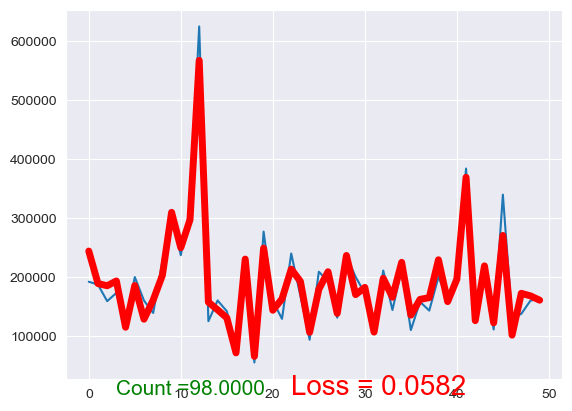

In [55]:
class HouseNet(nn.Module):
    def __init__(self,Din,H,Dout):
        super(HouseNet,self).__init__()
        self.hidden1 = nn.Linear(Din,H)
        self.hidden2 = nn.Linear(H,Dout)
        
    def forward(self,x):
        out = self.hidden1(x)
        out = torch.relu(out)
        out = self.hidden2(out)
        return out
    
model = HouseNet(345,79,1)

loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)

for it in range(100):
    for data in train_dataloader:
        x,y = data
        #print(x.size)
        #print(y)
        y_pred = model(x)
        # 把跑出的值与真实值做损失函数运算
        loss = loss_fn(y_pred, y)*0.0000000001
        #print(it,loss.item())
        
        # 把梯度置零
        optimizer.zero_grad()
        
        # 反向传播计算梯度值
        loss.backward()
        
        # 通过梯度下降更新参数
        optimizer.step()
        if it%2 ==0:
            plt.cla()
            display.clear_output(wait=True)
            plt.plot(y.data.numpy())
            plt.plot(y_pred.data.numpy(), 'r-', lw=5)
            plt.text(22, 33, 'Loss = %.4f' % loss.data, fontdict={'size': 20, 'color': 'red'})
            plt.text(3, 5, 'Count =%.4f' % it,fontdict={'size':15,'color':'green'})
            plt.pause(0.01)
        